## Parcial 1

MINE-4101: Ciencia de Datos Aplicada  
Universidad de los Andes  

Nombre: María Alejandra Pérez Petro

Código: 201923972

Fecha: Septiembre 22, 2025

In [253]:
import numpy as np
import pandas as pd

# visualizacion
import matplotlib.pyplot as plt
import seaborn as sns

# estadisticas
from scipy.stats import chi2_contingency, pearsonr, ttest_ind, f_oneway, levene, shapiro, kruskal
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.formula.api import ols

In [212]:
used_cars_df = pd.read_csv("used_cars_mod.csv")

*La siguiente es una estructura sugerida con base en la rúbrica de calificación.*



## **1. Entendimiento inicial**

Se revisan las dimensiones del dataset. Este cuenta con 23 columnas y 7400 filas

In [213]:
used_cars_df.shape

(7400, 23)

Se listan los atributos (columnas) del dataset y sus tipos

In [214]:
used_cars_df.dtypes

car_name               object
yr_mfr                float64
fuel_type              object
kms_run                 int64
sale_price              int64
city                   object
times_viewed            int64
body_type              object
transmission           object
variant                object
registered_city        object
registered_state       object
is_hot                   bool
make                   object
model                  object
total_owners            int64
broker_quote            int64
original_price        float64
car_rating             object
ad_created_on          object
booking_down_pymnt      int64
reserved                 bool
warranty_avail           bool
dtype: object

se muestran las primeras filas para entender la estructura de los datos


In [215]:
used_cars_df.head()

,car_name,yr_mfr,fuel_type,kms_run,sale_price,city,times_viewed,body_type,transmission,variant,...,make,model,total_owners,broker_quote,original_price,car_rating,ad_created_on,booking_down_pymnt,reserved,warranty_avail
0,maruti swift,2015.0,petrol,8063,386399,noida,18715,hatchback,manual,lxi opt,...,maruti,swift,0,397677,404177.0,great,2021-04-04T07:09:18.583,57960,False,False
1,maruti alto 800,2016.0,petrol,23104,265499,noida,2676,hatchback,manual,lxi,...,maruti,alto 800,1,272935,354313.0,great,2021-03-22T14:07:32.833,39825,False,False
2,hyundai grand i10,2017.0,petrol,23402,477699,noida,609,hatchback,manual,sports 1.2 vtvt,...,hyundai,grand i10,1,469605,NaN,great,2021-03-20T05:36:31.311,71655,False,False
3,maruti swift,2013.0,diesel,39124,307999,noida,6511,hatchback,manual,vdi,...,maruti,swift,1,294262,374326.0,great,2021-01-21T12:59:19.299,46200,False,False
4,hyundai grand i10,2015.0,petrol,22116,361499,noida,3225,hatchback,manual,magna 1.2 vtvt,...,hyundai,grand i10,1,360716,367216.0,great,2021-04-01T13:33:40.733,54225,False,False


### **Top 5 Caracteristicas**


1. **Precio de venta (`sale_price`):** Es la variable más crítica porque los compradores suelen tener un presupuesto definido. Permite filtrar opciones viables bajo el presupuesto del comprador.

2. **Año de fabricación (`yr_mfr`)**
Influye en la depreciación del carro. A mayor antigüedad, menor valor de reventa y mayor probabilidad de costos de mantenimiento.


3. **Kilometraje (`kms_run`):** Es un indicador directo del desgaste del vehículo. Un carro con menor kilometraje suele tener mejor estado mecánico, aunque depende de uso y mantenimiento.


4. **Tipo de combustible (`fuel_type`):** Determina el costo operativo (ej. gasolina vs. diésel vs. eléctrico). Importante para compradores que priorizan ahorro en consumo o sostenibilidad.


5. **Transmisión (`transmission`):** Es clave para la experiencia de manejo y preferencias del usuario (manual vs. automática). También afecta el valor de reventa según el mercado.


Con estas 5 variables se puede construir un **score compuesto** que permita establecer un ranking sobre todos los autos y que combine:
* **Relación precio/año** (valor vs antigüedad).
* **Relación precio/km** (costo relativo al uso).
* **Ajuste por combustible y transmisión** (según preferencias del perfil del comprador).

## **2. Análisis de calidad y preparación de datos**

Dimensiones de calidad:
1. Completitud: Valores nulos​
2. Unicidad: Detectar valores duplicados
3. Consistencia: Validación de los tipos de datos

En un primer acercamiento, revisamos completitud y unicidad sobre todo el dataset.

In [216]:
#Revisamos valores nulos sobre todo el dataset
display(used_cars_df.isna().sum())
numero_filas_con_nulos = used_cars_df.isna().any(axis=1).sum()
print(f"Número de filas con al menos un valor nulo: {numero_filas_con_nulos}, lo que representa el {numero_filas_con_nulos / used_cars_df.shape[0] * 100:.2f}% del total de filas.")
# Revisamos duplicados sobre todo el dataset
num_duplicados = used_cars_df.duplicated().sum()
print(f"Número de duplicados: {num_duplicados} (%{num_duplicados/len(used_cars_df)*100:.2f})")

car_name                 0
yr_mfr                   5
fuel_type                4
kms_run                  0
sale_price               0
city                     0
times_viewed             0
body_type              103
transmission           556
variant                  0
registered_city         10
registered_state        10
is_hot                   0
make                     5
model                    0
total_owners             0
broker_quote             0
original_price        3280
car_rating               9
ad_created_on            1
booking_down_pymnt       0
reserved                 0
warranty_avail           0
dtype: int64

Número de filas con al menos un valor nulo: 3656, lo que representa el 49.41% del total de filas.
Número de duplicados: 1 (%0.01)


Conservamos solo las columnas de interes

In [217]:
columnas_relevantes = ["sale_price", "yr_mfr", "kms_run", "fuel_type", "transmission"]
df = used_cars_df[columnas_relevantes]

**2.1 Completitud**

In [218]:
#Revisamos valores nulos
df.isna().sum()

sale_price        0
yr_mfr            5
kms_run           0
fuel_type         4
transmission    556
dtype: int64

In [219]:

numero_filas_con_nulos = df.isna().any(axis=1).sum()
print(f"Número de filas con al menos un valor nulo: {numero_filas_con_nulos}, lo que representa el {numero_filas_con_nulos / df.shape[0] * 100:.2f}% del total de filas.")

Número de filas con al menos un valor nulo: 563, lo que representa el 7.61% del total de filas.


Estrategia: conservar solo las filas que presenten completitud en las cinco columnas de interés.

In [220]:
df_clean = df.dropna(subset=columnas_relevantes)

**2.2 Unicidad**

In [221]:
# Revisamos duplicados
num_duplicados = df.duplicated().sum()
print(f"Número de duplicados: {num_duplicados} (%{num_duplicados/len(df)*100:.2f})")

Número de duplicados: 1 (%0.01)


Estrategia: eliminamos duplicados.

In [222]:
df_clean = df_clean.drop_duplicates()

**2.3 Consistencia**

En está sección nuestro objetivo es validar los tipos de datos y las distribuciones de las variables de interes seleccionadas.
- Variables númericas: Precio de venta (`sale_price`), Año de fabricación (`yr_mfr`), Kilometraje (`kms_run`)
- Variables Categoricas: Transmisión (`transmission`), Tipo de combustible (`fuel_type`)

#### **Precio de venta (`sale_price`)**


In [223]:
df_clean["sale_price"].describe()

count    6.836000e+03
mean     4.352957e+05
std      2.645279e+05
min      0.000000e+00
25%      2.756740e+05
50%      3.731990e+05
75%      5.177490e+05
max      3.866000e+06
Name: sale_price, dtype: float64

Observamos que no hay valores negativos en el precio de venta y que el minimo es 0, lo cual, es acorde a lo esperado para una variable de precio.

C:\Users\maril\AppData\Local\Temp\ipykernel_14240\1736589437.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()


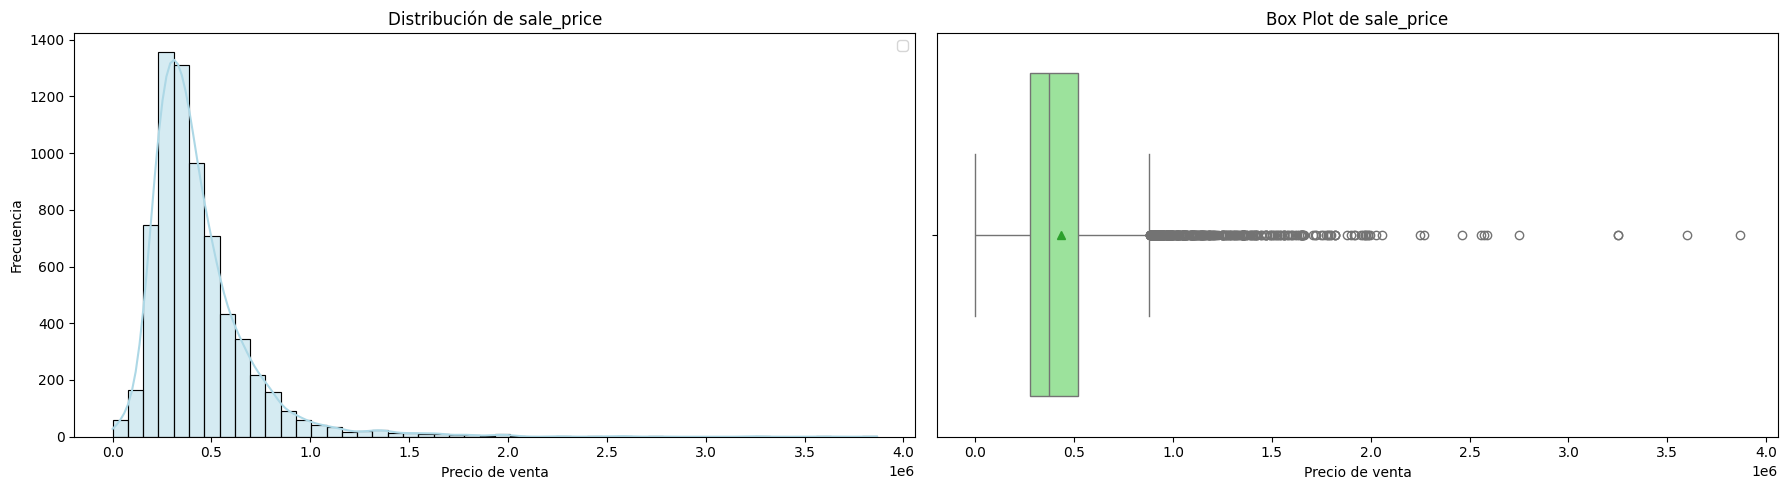

In [224]:
# Visualización
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))

columna_a_graficar = 'sale_price'
# Histograma con KDE
sns.histplot(x = df_clean[columna_a_graficar], bins=50, kde=True, ax=ax1, color='lightblue')
ax1.set_title(f'Distribución de {columna_a_graficar}')
ax1.set_xlabel('Precio de venta')
ax1.set_ylabel('Frecuencia')
#ax1.axvline(lead_time_stats['mean'], color='red', linestyle='--', label=f'Media: {lead_time_stats["mean"]:.1f} días')
#ax1.axvline(lead_time_stats['50%'], color='blue', linestyle='--', label=f'Mediana: {lead_time_stats["50%"]:.1f} días')
ax1.legend()

# Boxplot horizontal
sns.boxplot(x=df_clean[columna_a_graficar], ax=ax2, color='lightgreen', showmeans=True)
ax2.set_title(f'Box Plot de {columna_a_graficar}')
ax2.set_xlabel('Precio de venta')
ax2.set_ylabel('')

plt.tight_layout()
plt.show()

#### **Año de fabricación (`yr_mfr`)**

In [225]:
df_clean['yr_mfr'].describe()

count    6836.000000
mean     2013.214160
std        27.212573
min        12.000000
25%      2012.000000
50%      2014.000000
75%      2016.000000
max      2030.000000
Name: yr_mfr, dtype: float64

Observamos un minimo en el año de fabricación de 12, lo cual, no tiene sentido puesto que los primeros intentos datan del siglo XVIII (Según Google). Por lo que se limpiaran las filas con valores inferiorores a 1700.

In [226]:
# revisamos cantidad de filas con "yr_mfr" menor a 1700
print(f"Número de filas con 'yr_mfr' menor a 1700: {(df_clean['yr_mfr'] < 1700).sum()}")

Número de filas con 'yr_mfr' menor a 1700: 2


In [227]:
# remover filas con valores de 'yr_mfr' menores a 1700
df_clean = df_clean[df_clean['yr_mfr'] >= 1700]


Ya que no es razonable fechas de fabricación que corresponden a años en el "futuro", removemos años psoteriores a 2025.

In [228]:
# revisamos cantidad de filas con "yr_mfr" mayor a 2025
print(f"Número de filas con 'yr_mfr' mayor a 2025: {(df_clean['yr_mfr'] > 2025).sum()}")

Número de filas con 'yr_mfr' mayor a 2025: 1


In [229]:
df_clean = df_clean[df_clean['yr_mfr'] <= 2025]

Finalmente, se convierte la columna a pd.datetime, puesto que hace referencia a años de fabricación

In [230]:
df_clean['yr_mfr'] = pd.to_datetime(df_clean['yr_mfr'], format='%Y').dt.year
df_clean['yr_mfr']

0       2015
1       2016
2       2017
3       2013
4       2015
        ... 
7393    2012
7394    2002
7396    2018
7397    2015
7398    2016
Name: yr_mfr, Length: 6833, dtype: int32

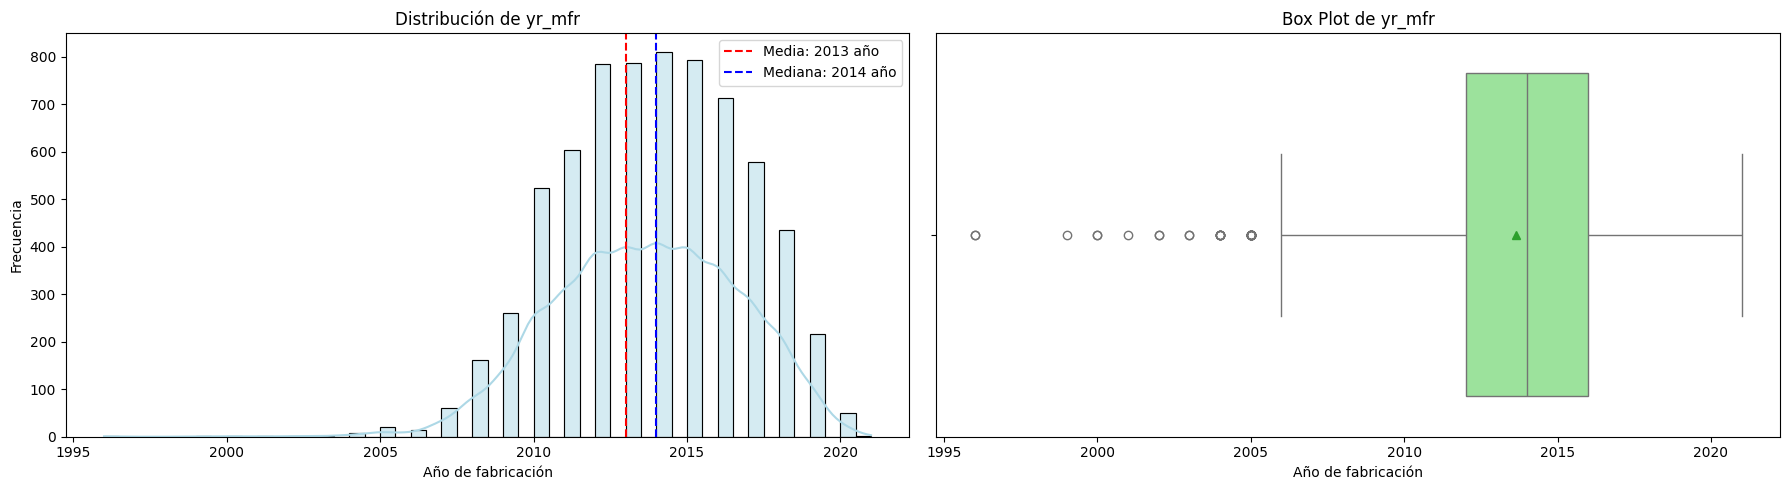

In [231]:
# Visualización
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))

columna_a_graficar = 'yr_mfr'
nombre_columa = 'Año de fabricación'
columna_stats = df_clean[columna_a_graficar].describe()
# Histograma con KDE
sns.histplot(x = df_clean[columna_a_graficar], bins=50, kde=True, ax=ax1, color='lightblue')
ax1.set_title(f'Distribución de {columna_a_graficar}')
ax1.set_xlabel(nombre_columa)
ax1.set_ylabel('Frecuencia')
ax1.axvline(int(columna_stats['mean']), color='red', linestyle='--', label=f'Media: {int(columna_stats["mean"])} año')
ax1.axvline(int(columna_stats['50%']), color='blue', linestyle='--', label=f'Mediana: {int(columna_stats["50%"])} año')
ax1.legend()

# Boxplot horizontal
sns.boxplot(x=df_clean[columna_a_graficar], ax=ax2, color='lightgreen', showmeans=True)
ax2.set_title(f'Box Plot de {columna_a_graficar}')
ax2.set_xlabel(nombre_columa)
ax2.set_ylabel('')

plt.tight_layout()
plt.show()

#### **Kilometraje (`kms_run`)**

In [232]:
df_clean['kms_run'].describe()

count      6833.000000
mean      64242.404654
std       41945.557538
min           0.000000
25%       34304.000000
50%       57730.000000
75%       85595.000000
max      640251.000000
Name: kms_run, dtype: float64

Observamos que no hay valores de kilometraje negativos y el minimo es cero, lo cual es acorde a lo esperado para la variable.

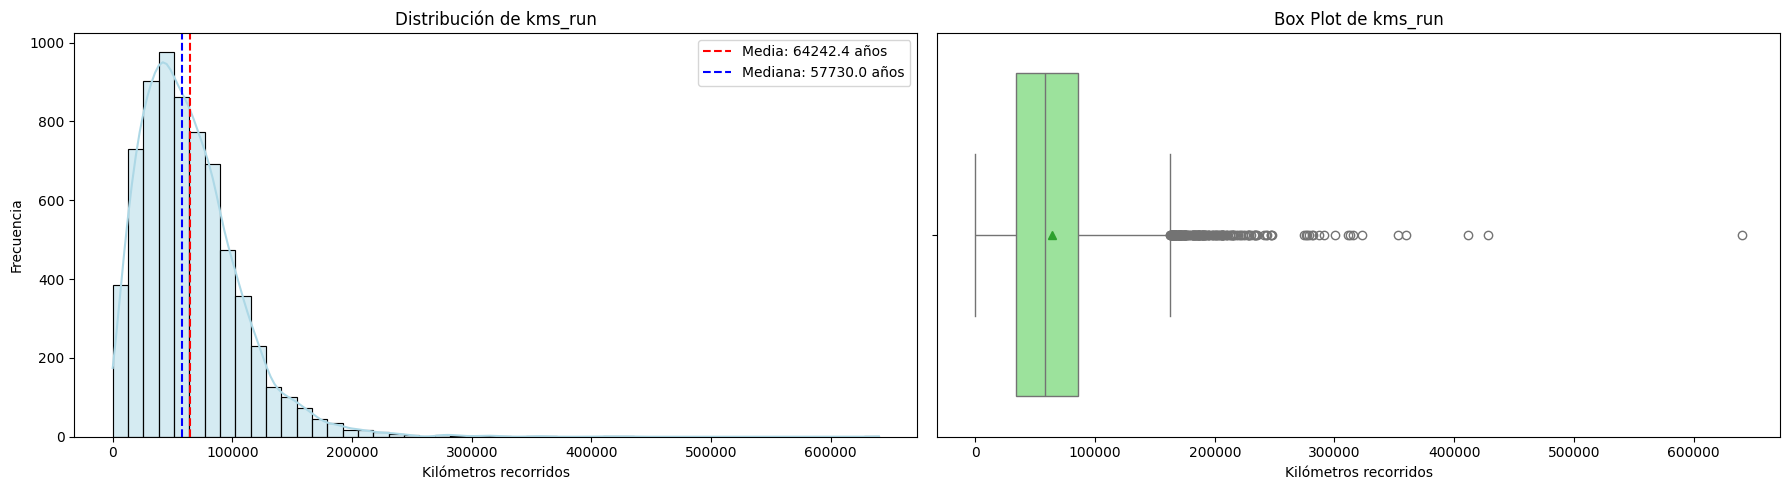

In [233]:
# Visualización
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))

columna_a_graficar = 'kms_run'
nombre_columna = 'Kilómetros recorridos'
columna_stats = df_clean[columna_a_graficar].describe()

# Histograma con KDE
sns.histplot(x = df_clean[columna_a_graficar], bins=50, kde=True, ax=ax1, color='lightblue')
ax1.set_title(f'Distribución de {columna_a_graficar}')
ax1.set_xlabel(nombre_columna)
ax1.set_ylabel('Frecuencia')
ax1.axvline(columna_stats['mean'], color='red', linestyle='--', label=f'Media: {columna_stats["mean"]:.1f} años')
ax1.axvline(columna_stats['50%'], color='blue', linestyle='--', label=f'Mediana: {columna_stats["50%"]:.1f} años')
ax1.legend()

# Boxplot horizontal
sns.boxplot(x=df_clean[columna_a_graficar], ax=ax2, color='lightgreen', showmeans=True)
ax2.set_title(f'Box Plot de {columna_a_graficar}')
ax2.set_xlabel(nombre_columna)
ax2.set_ylabel('')

plt.tight_layout()
plt.show()

#### **Transmisión (`transmission`)**

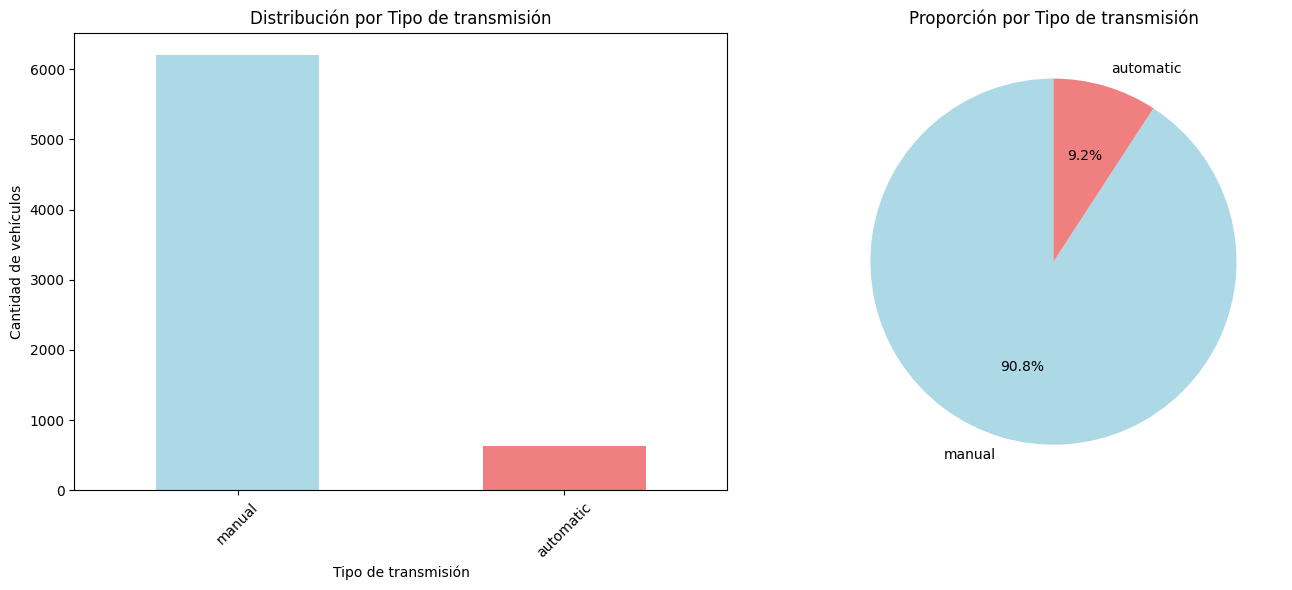

In [234]:
columna = "transmission"
nombre_columna = "Tipo de transmisión"
columna_stats = df_clean[columna].value_counts()
columna_pct = df_clean[columna].value_counts(normalize=True) * 100


# Visualización
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# colores
paleta =  ['lightblue', 'lightcoral']

# Gráfico de barras
columna_stats.plot(kind='bar', ax=ax1, color=paleta)
ax1.set_title(f'Distribución por {nombre_columna}')
ax1.set_xlabel(nombre_columna)
ax1.set_ylabel('Cantidad de vehículos')
ax1.tick_params(axis='x', rotation=45)

# Gráfico de pastel
ax2.pie(columna_stats.values, labels=columna_stats.index, autopct='%1.1f%%', 
        startangle=90, colors=paleta)
ax2.set_title(f'Proporción por {nombre_columna}')

plt.tight_layout()
plt.show()


Vemos que el tipo de Transmisión (`transmission`) es una variable categórica con solo dos posibles valores: automatic y manual.

#### **Tipo de combustible (`fuel_type`)**

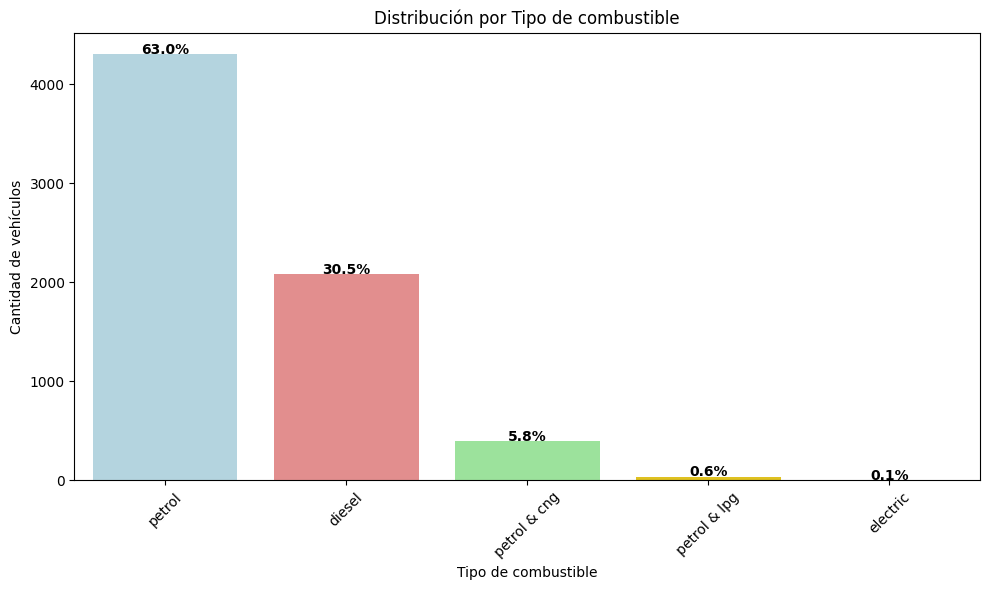

In [235]:
columna = "fuel_type"
nombre_columna = "Tipo de combustible"

columna_stats = df_clean[columna].value_counts()
columna_pct = df_clean[columna].value_counts(normalize=True) * 100

# Crear DataFrame auxiliar para graficar
df_plot = columna_stats.reset_index()
df_plot.columns = [columna, "count"]
df_plot["pct"] = columna_pct.values

# Colores
paleta = ['lightblue', 'lightcoral', 'lightgreen', 'gold', "violet"]

# Gráfico con seaborn
plt.figure(figsize=(10,6))
ax = sns.barplot(data=df_plot, x=columna,y="count", palette=paleta, hue = columna)
ax.set_title(f"Distribución por {nombre_columna}")
ax.set_xlabel(nombre_columna)
ax.set_ylabel("Cantidad de vehículos")

# Agregar porcentajes sobre cada barra
for i, row in df_plot.iterrows():
    ax.text(i, row["count"] + 0.5, f'{row["pct"]:.1f}%', 
            ha='center', fontsize=10, fontweight="bold")

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Vemos que el Tipo de combustible (`fuel_type`) es una variable categórica con solo cinco posibles valores: petrol, diesel, petrol & cng, petrol & Ipg y electic.

Revisamos las dimensiones finales del dataset que se va a utilizar para el análisis, luego de aplicar las estrategias de calidad de datos:

In [236]:
df_clean.shape

(6833, 5)

## **3. Relaciones entre variables**

La estrategia de análisis se enfocará en estudiar la relación entre la variable objetivo `sale_price` y los factores seleccionados asociados al comportamiento del precio del vehiculo (`yr_mfr`, `kms_run`, `fuel_type`, `transmission`)

### **3.1 Análisis de correlaciones**

In [237]:
def calculate_and_plot_correlation_matrix(df_num, method='pearson', mask = False):
    correlation_matrix = df_num.corr(method=method)

    # Crear máscara para ocultar la parte inferior
    mask = None if not mask else np.triu(np.ones_like(correlation_matrix, dtype=bool))

    # Heatmap solo parte superior
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, 
                mask=mask,
                annot=True, 
                cmap='RdBu_r', 
                center=0,
                square=True,
                fmt='.3f',
                cbar_kws={'label': 'Coeficiente de Correlación'})
    plt.title(f'Matriz de Correlación ({method.capitalize()})')
    plt.tight_layout()
    plt.show()
    return correlation_matrix


In [238]:
# Crear matriz de correlación para variables numéricas
numeric_vars = ["sale_price", "yr_mfr", "kms_run"]
df_numeric = df_clean[numeric_vars]

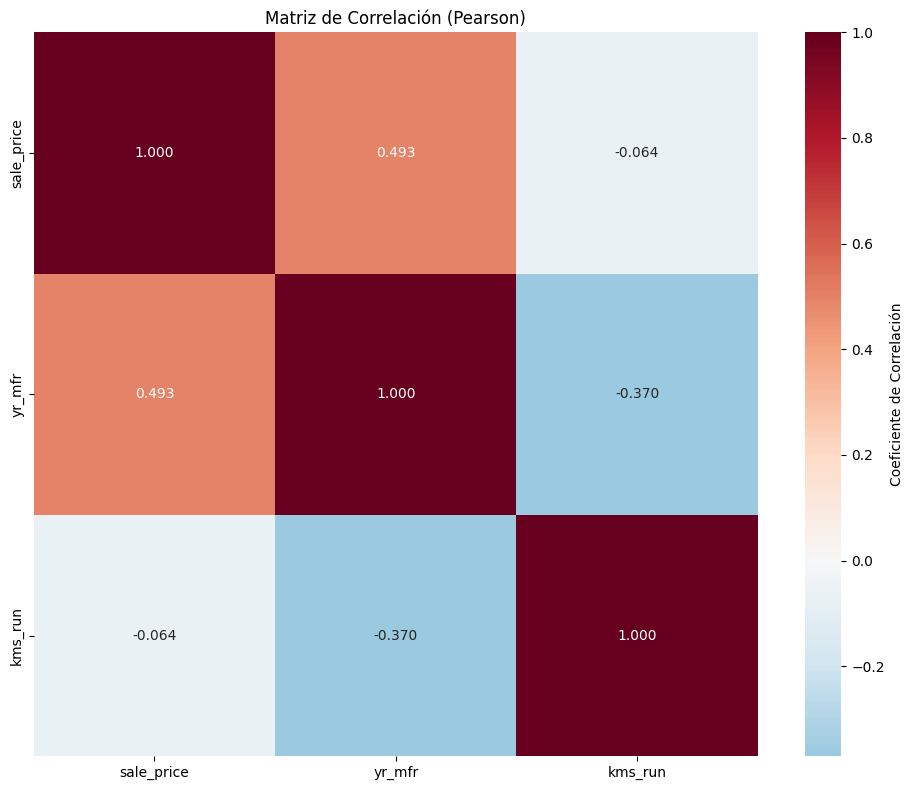

In [239]:
# Correlacion de Pearson
correlation_matrix = calculate_and_plot_correlation_matrix(df_numeric, method='pearson')

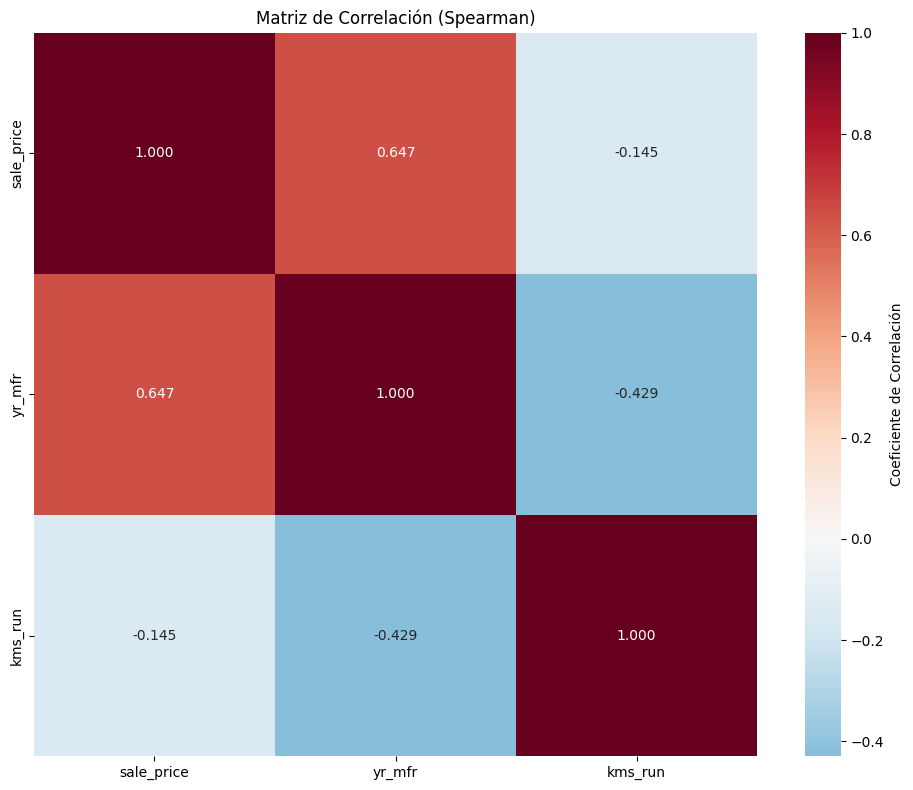

In [240]:
# Correlacion de Spearman
correlation_matrix = calculate_and_plot_correlation_matrix(df_numeric, method='spearman')

El análisis de correlaciones muestra que el año de fabricación es el factor más fuerte y consistente en la determinación del precio de venta**. Con el coeficiente de **Pearson (0.492)** y aún más con el de **Spearman (0.646)**, se confirma que los vehículos más recientes tienden a tener un mayor valor de mercado (correlación positiva). En contraste, el kilometraje influye mucho menos: su relación con el precio es débil tanto en Pearson (**-0.064**) como en Spearman (**-0.145**), lo que indica que recorrer más kilómetros no siempre se traduce en una caída proporcional del precio (correlación negativa). Finalmente, se observa que las correlaciones bajo el método de Spearman resultan más claras que con Pearson, lo que sugiere que estas variables están relacionadas pero no de manera estrictamente lineal.


### **3.2 Análisis Bivariado**

#### **Precio de venta vs año de fabricacion**

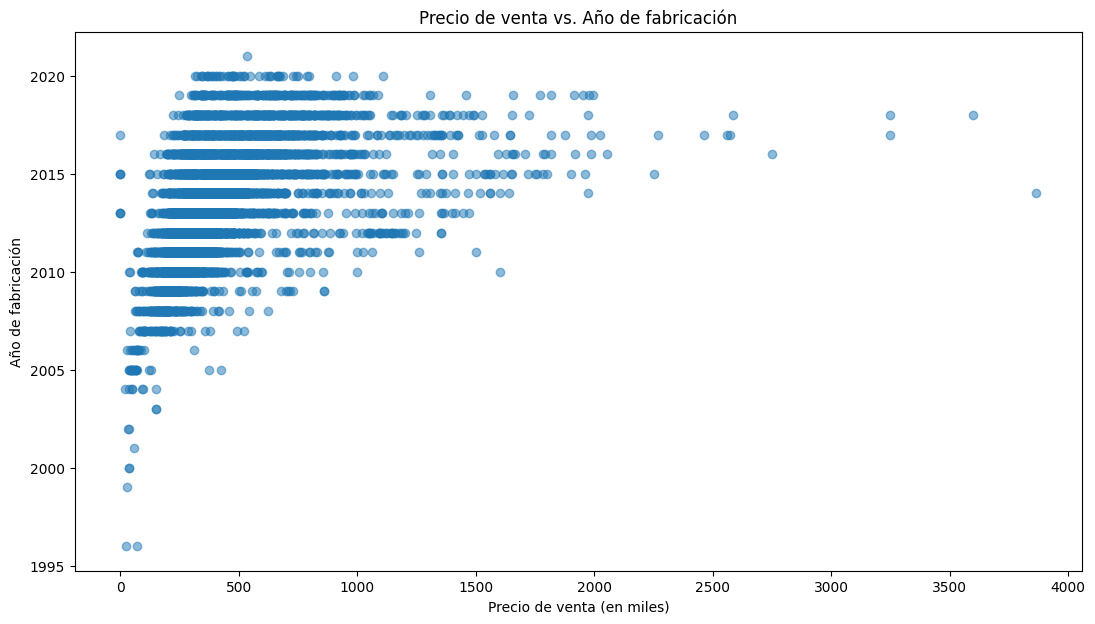

In [241]:
# Plotting a scatter plot to visualize two quantitative variables
var1 = "sale_price"
var1_name = "Precio de venta"
var2 = "yr_mfr"
var2_name = "Año de fabricación"
plt.figure(figsize=(13, 7))
plt.scatter(df_clean[var1]/1000, df_clean[var2], alpha=0.5)
plt.title(f'{var1_name} vs. {var2_name}')
plt.xlabel(f'{var1_name} (en miles)')
plt.ylabel(f'{var2_name}')
plt.show()

En la relación entre el precio de venta (`sale_price`) y el año de fabricación (`yr_mfr`), se observa una clara tendencia: los vehículos más recientes (posteriores a 2015) tienden a concentrarse en rangos de precios más altos, mientras que los modelos más antiguos se asocian con valores más bajos. Sin embargo, existen algunos outliers de vehículos de modelos recientes con precios inusualmente bajos y, en menor medida, modelos antiguos con precios elevados, posiblemente debido a características premium, rareza o buen estado de conservación. En general, el año de fabricación muestra una relación positiva con el valor de venta: a mayor antigüedad, menor precio de mercado.

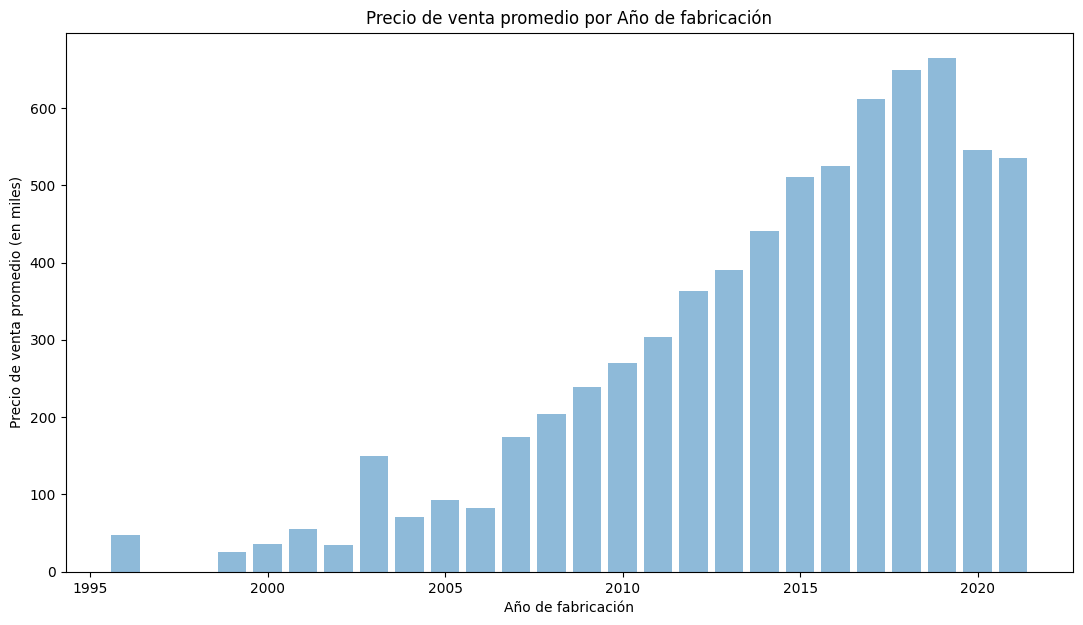

In [242]:

df_temp = df_clean.groupby("yr_mfr")["sale_price"].mean().reset_index()
plt.figure(figsize=(13, 7))
plt.bar(df_temp["yr_mfr"], df_temp["sale_price"]/1000, alpha=0.5)
plt.title('Precio de venta promedio por Año de fabricación')
plt.xlabel('Año de fabricación')
plt.ylabel('Precio de venta promedio (en miles)')
plt.show()

#### **Precio de venta vs kilometros recorridos**

<Figure size 1300x700 with 0 Axes>

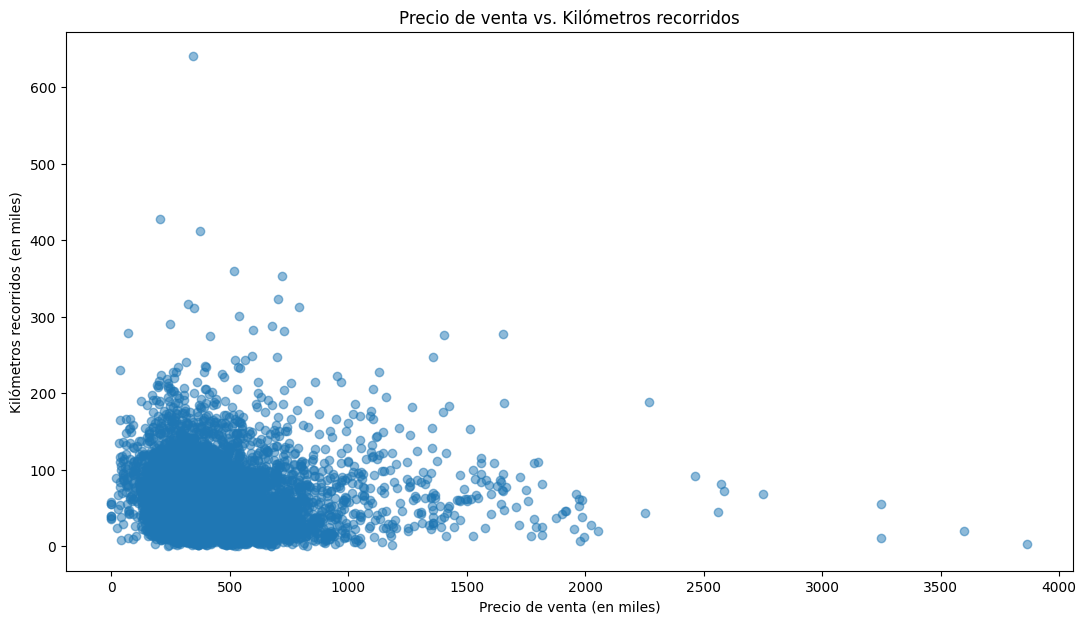

In [243]:
plt.figure(figsize=(13,7))
var1 = "sale_price"
var1_name = "Precio de venta"
var2 = "kms_run"
var2_name = "Kilómetros recorridos"
plt.figure(figsize=(13, 7))
plt.scatter(df_clean[var1]/1000, df_clean[var2]/1000, alpha=0.5)
plt.title(f'{var1_name} vs. {var2_name}')
plt.xlabel(f'{var1_name} (en miles)')
plt.ylabel(f'{var2_name} (en miles)')
plt.show()

El análisis entre `sale_price` y `kms_run` confirma un patrón esperado: a mayor kilometraje recorrido, el precio de venta tiende a disminuir. Existe una alta densidad de vehículos en un rango intermedio de kilometraje (0–200 mil km) y precios relativamente bajos (menores a 1 millón en la escala del gráfico), lo cual indica que el mercado es más competitivo en esa franja. Se identifican también valores atípicos con alto kilometraje y precios aún elevados, lo cual podría estar explicado por vehículos de gama alta o con excelente mantenimiento. En síntesis, el kilometraje se comporta como un fuerte determinante negativo del valor de reventa.

C:\Users\maril\AppData\Local\Temp\ipykernel_14240\774198129.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_prices = df_clean.groupby("kms_bin")["sale_price"].mean().reset_index()


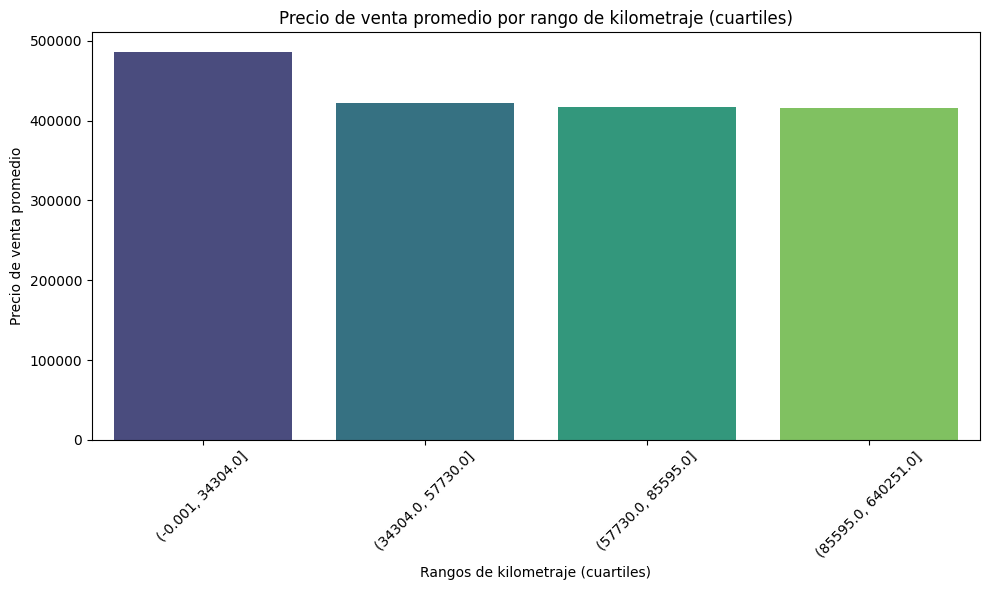

In [244]:
# Crear los bins por cuartiles (ejemplo: 4 grupos = 25% cada uno)
df_clean["kms_bin"] = pd.qcut(df_clean["kms_run"], q=4, duplicates="drop")

# Calcular promedio de precio por rango de bins
avg_prices = df_clean.groupby("kms_bin")["sale_price"].mean().reset_index()

# Gráfico de barras
plt.figure(figsize=(10,6))
sns.barplot(data=avg_prices, x="kms_bin", y="sale_price", palette="viridis", hue = "kms_bin", legend=False)

plt.title("Precio de venta promedio por rango de kilometraje (cuartiles)")
plt.xlabel("Rangos de kilometraje (cuartiles)")
plt.ylabel("Precio de venta promedio")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### **Precio de venta vs Tipo de trasmision**

In [245]:
grupo1 = df[df['transmission']=='manual']['sale_price'].dropna()
grupo2 = df[df['transmission']=='automatic']['sale_price'].dropna()

g1_stats = grupo1.describe().round(2)
g2_stats = grupo2.describe().round(2)

# concatenar los estadísticos en un solo DataFrame para mejor visualización
estadisticos = pd.DataFrame({
    'Manual': g1_stats,
    'Automatic': g2_stats
})
estadisticos 

,Manual,Automatic
count,6215.00,629.00
mean,407635.75,707887.26
std,218895.49,453896.10
min,0.00,0.00
25%,268899.00,401000.00
50%,359899.00,581699.00
75%,492999.50,902099.00
max,3250000.00,3866000.00


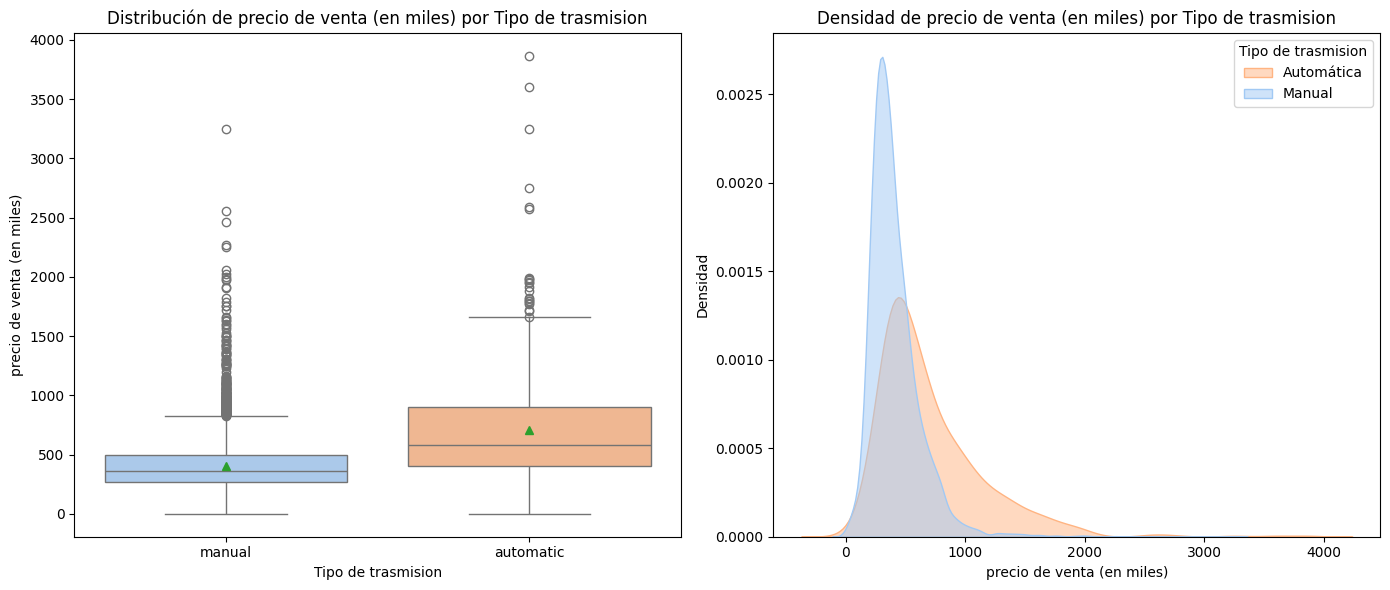

In [246]:
# Visualización
df_clean["sale_price_miles"] = df_clean["sale_price"] / 1000  

var1= "sale_price_miles"
name_var1 = "precio de venta (en miles)"
var2 = "transmission"
name_var2 = "Tipo de trasmision"

# --- 1. Boxplot comparativo ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

sns.boxplot(
    data=df_clean,
    x=var2,
    y=var1,
    palette="pastel",
    ax=ax1,
    showmeans = True,
    hue = var2
)

ax1.set_title(f"Distribución de {name_var1} por {name_var2}")
ax1.set_xlabel(name_var2)
ax1.set_ylabel(name_var1)


# 2 -- Histogramas/densidades superpuestos con Seaborn
sns.kdeplot(
    data=df_clean,
    x=var1,
    hue=var2,
    fill=True,
    common_norm=False,
    alpha=0.5,
    palette="pastel",
    ax=ax2
)
ax2.set_title(f'Densidad de {name_var1} por {name_var2}')
ax2.set_xlabel(name_var1)
ax2.set_ylabel("Densidad")
ax2.legend(title = name_var2, labels = [ "Automática", "Manual"])

plt.tight_layout()
plt.show()

El análisis de `sale_price` según el tipo de transmisión evidencia una diferencia clara: los vehículos automáticos presentan precios de venta más altos, con un promedio cercano a 708 mil frente a 408 mil en los manuales. Además, la mediana y los cuartiles de los automáticos se ubican consistentemente por encima de los manuales, lo que confirma una brecha de valor clara. La dispersión también es mayor en automáticos (desviación estándar ≈ 454 mil frente a 219 mil), debido quizas a la presencia de modelos premium que elevan los precios. La distribución de densidad confirma este patrón, mostrando que los manuales se concentran en rangos bajos (300–500 mil), mientras que los automáticos desplazan su masa hacia segmentos de precio más altos, lo que sugiere que la transmisión automática está asociada a vehículos de mayor gama, mientras que los manuales predominan en categorías más económicas e intermedias.


#### **Precio de venta vs Tipo de combustible**

In [247]:
var2 = "fuel_type"
labels_var2 = df_clean[var2].unique()
dicc_stats = {}
for tipo in labels_var2:
    grupo = df_clean[df_clean['fuel_type']==tipo]['sale_price_miles'].dropna()
    stats = grupo.describe().round(2)
    dicc_stats[tipo] = stats

# concatenar los estadísticos en un solo DataFrame para mejor visualización
pd.DataFrame(dicc_stats)

,petrol,diesel,petrol & cng,electric,petrol & lpg
count,4306.00,2084.00,399.00,5.00,39.00
mean,374.33,590.23,306.34,309.36,229.80
std,172.15,359.16,136.04,48.08,62.98
min,0.00,0.00,20.00,259.00,35.00
25%,256.52,361.47,232.30,267.20,194.85
50%,342.75,491.75,300.00,304.20,238.60
75%,461.40,717.72,371.45,350.00,263.35
max,2024.00,3866.00,850.00,366.40,398.70


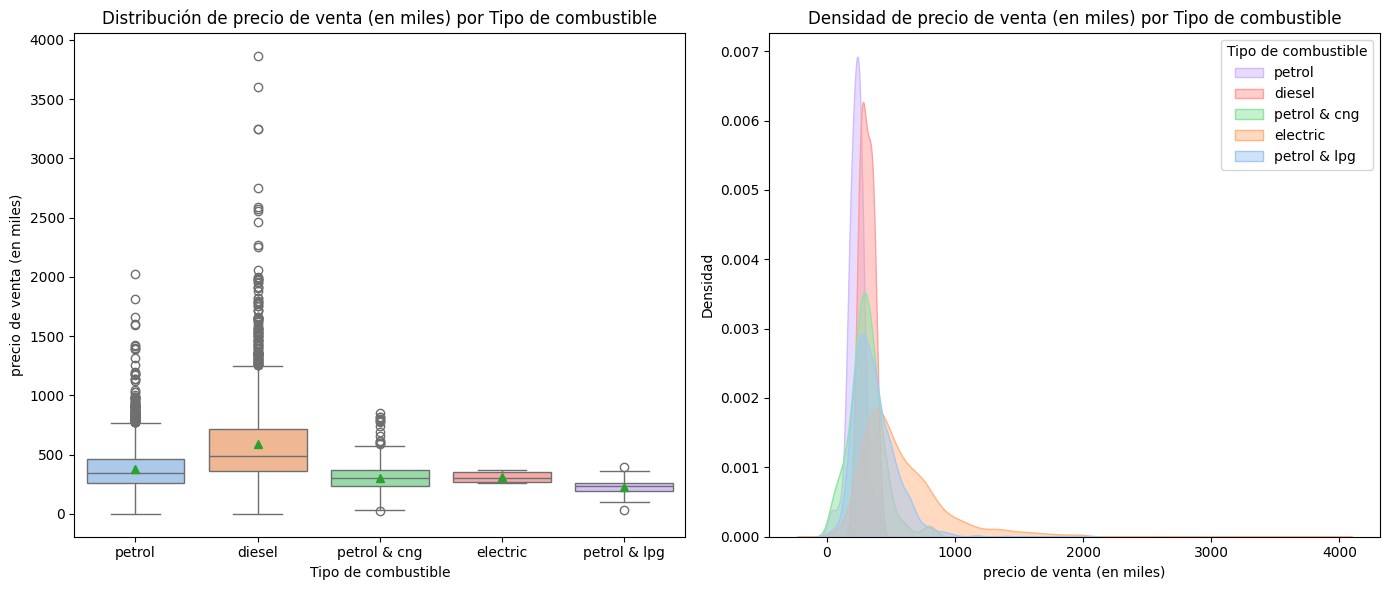

In [248]:
df_clean["sale_price_miles"] = df_clean["sale_price"] / 1000  

var1= "sale_price_miles"
name_var1 = "precio de venta (en miles)"
var2 = "fuel_type"
name_var2 = "Tipo de combustible"
labels_var2 = df_clean[var2].unique()

# --- 1. Boxplot comparativo ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

sns.boxplot(
    data=df_clean,
    x=var2,
    y=var1,
    palette="pastel",
    ax=ax1,
    showmeans = True,
    hue = var2
)

ax1.set_title(f"Distribución de {name_var1} por {name_var2}")
ax1.set_xlabel(name_var2)
ax1.set_ylabel(name_var1)


# 2 -- Histogramas/densidades superpuestos con Seaborn
sns.kdeplot(
    data=df_clean,
    x=var1,
    hue=var2,
    fill=True,
    common_norm=False,
    alpha=0.5,
    palette="pastel",
    ax=ax2
)
ax2.set_title(f'Densidad de {name_var1} por {name_var2}')
ax2.set_xlabel(name_var1)
ax2.set_ylabel("Densidad")
ax2.legend(title = name_var2, labels = labels_var2)

plt.tight_layout()
plt.show()

El análisis de `sale_price` por tipo de combustible muestra diferencias claras en los precios. Los vehículos diésel son los que alcanzan los valores más altos, con una mediana cercana a 492 mil y algunos casos que superan los 3.8 millones, lo que refleja la presencia de modelos de gama alta. Los de gasolina son el grupo más común y se ubican en precios intermedios, con una mediana alrededor de 343 mil y menor variabilidad que los diésel. Los eléctricos, por su parte, se concentran en un rango más estrecho, entre 259 y 366 mil, lo que indica que todavía hay una oferta más limitada. En cuanto a las combinaciones con gas (CNG o LPG), presentan los precios más bajos, lo que confirma que suelen corresponder a vehículos más económicos. Al ver la densidad, se nota que los diésel se desplazan hacia precios más altos, mientras que gasolina y las opciones a gas se concentran en rangos bajos y medios. En resumen, el combustible es un factor importante en el valor de mercado: el diésel se asocia con vehículos más costosos y robustos, la gasolina domina por volumen con precios moderados y las alternativas con gas se ubican en el segmento más económico.


## **4. Pruebas de hipótesis**

### **t-test: comparación de medias de `sale_price` según `transmission`**

**Formulación de hipótesis Prueba t de Student (comparación de medias):**

* H₀: μ\_manual = μ\_automatic → El precio de venta promedio es igual para transmisiones manuales y automáticas.
* H₁: μ\_manual ≠ μ\_automatic → El precio de venta promedio difiere entre transmisiones manuales y automáticas.



**Supuestos del t-test**

1. **Independencia:**
   Las observaciones de cada grupo son independientes entre sí.
   (Se asume que cada auto corresponde a un registro único, no hay datos repetidos).

2. **Normalidad:**
   La distribución de `sale_price` en cada grupo sigue aproximadamente una distribución normal.
   (Con tamaños de muestra grandes, el Teorema Central del Límite permite cierta robustez).

3. **Homogeneidad de varianzas:**
   * Para verificar esto usaremos la Prueba de Levene:
     * H₀: Las varianzas de `sale_price` son iguales en los dos grupos (`manual` y `automatic`).
     * H₁: Al menos un grupo tiene varianza distinta.
   * Si Levene p > 0.05 → se asumen varianzas iguales, se usa el t-test clásico.
   * Si Levene p ≤ 0.05 → se asumen varianzas distintas, se usa el t-test de Welch (más robusto).


**Interpretación de los resultados**

* Si `p < 0.05` en el t-test → se **rechaza H₀**, concluyendo que existe una **diferencia significativa** en el precio promedio entre autos manuales y automáticos.
* Si `p ≥ 0.05` → **no se rechaza H₀**, no hay evidencia suficiente para decir que difieren en precio promedio.




In [249]:

def test_sale_price_transmission(df):
    grupo1 = df_clean[df_clean['transmission']=='manual']['sale_price']
    grupo2 = df_clean[df_clean['transmission']=='automatic']['sale_price']

    # Prueba de igualdad de varianzas
    stat_levene, p_levene = levene(grupo1, grupo2)
    print("Levene p:", p_levene)

    # t-test
    t, p = ttest_ind(grupo1, grupo2, equal_var=(p_levene>0.05))
    print("t-test: t=", t, "p=", p)

    if p < 0.05:
        print(f"Rechazamos la hipótesis nula: Hay diferencia significativa en sale_price entre tipos de transmisión.")
    else:
        print(f"No rechazamos la hipótesis nula: No hay diferencia significativa en sale_price entre tipos de transmisión.")


test_sale_price_transmission(df_clean)

Levene p: 1.385630583582861e-88
t-test: t= -16.365880141654408 p= 9.54616935053286e-51
Rechazamos la hipótesis nula: Hay diferencia significativa en sale_price entre tipos de transmisión.


Hay evidencia estadistica de que los autos automáticos son más caros en promedio que los manuales. La magnitud del t (valor absoluto grande) y el p-valor extremadamente bajo refuerzan que la diferencia no es por azar.

### **Anova: comparación de medias de `sale_price` según `fuel_type`**


**Formulación de hipótesis ANOVA de un factor (sale\_price según fuel\_type):**

* **Hipótesis nula (H₀):** Todas las medias de `sale_price` son iguales entre los distintos tipos de combustible.

$$H_0: \mu_{\text{diesel}} = \mu_{\text{petrol}} = \mu_{\text{electric}} = \mu_{\text{petrol\&CNG}} = \mu_{\text{petrol\&LPG}}$$

* **Hipótesis alternativa (H₁):** Al menos una media de `sale_price` difiere de las demás. (No especifica cuál, solo que existe diferencia en algún grupo).



**Supuestos del ANOVA**

1. **Independencia de las observaciones:** Cada precio de venta corresponde a un auto distinto, sin dependencia entre registros.

2. **Normalidad:** La distribución de `sale_price` en cada grupo de `fuel_type` sigue aproximadamente una distribución normal.

3. **Homogeneidad de varianzas:** Las varianzas de `sale_price` son similares entre los grupos de `fuel_type`.
   Esto se suele comprobar con la prueba de Levene o Bartlett.





In [250]:
# verificamos normalidad
print("=== Prueba de normalidad para  `sale_price` en cada grupo de `fuel_type` ===\n")

for name, grupo in df_clean.groupby('fuel_type'):
    stat, p = shapiro(grupo['sale_price'])
    print(f"\n{name}: Estadistico (W)={stat:.3f}, p={p:.5f}")
    # Resultado escrito
    if p < 0.05:
        print("Rechazamos la hipótesis nula, por lo que no se cumple la normalidad")
    else:
        print("No podemos rechazar la hipótesis nula, es decir, no hay evidencia suficiente para afirmar que la variable sale_price se desvia de una distribución normal para este grupo")

=== Prueba de normalidad para  `sale_price` en cada grupo de `fuel_type` ===


diesel: Estadistico (W)=0.793, p=0.00000
Rechazamos la hipótesis nula, por lo que no se cumple la normalidad

electric: Estadistico (W)=0.903, p=0.42625
No podemos rechazar la hipótesis nula, es decir, no hay evidencia suficiente para afirmar que la variable sale_price se desvia de una distribución normal para este grupo

petrol: Estadistico (W)=0.897, p=0.00000
Rechazamos la hipótesis nula, por lo que no se cumple la normalidad

petrol & cng: Estadistico (W)=0.947, p=0.00000
Rechazamos la hipótesis nula, por lo que no se cumple la normalidad

petrol & lpg: Estadistico (W)=0.944, p=0.05181
No podemos rechazar la hipótesis nula, es decir, no hay evidencia suficiente para afirmar que la variable sale_price se desvia de una distribución normal para este grupo


Como no se cumple la prueba de normalidad, no podemos hacer un ANOVA. Por lo que haremos una prueba de Kruskal-Wallis para comparar los precios de autos con diferentes tipos de combustible. Kruskal–Wallis es robusto porque no exige normalidad ni homogeneidad de varianzas, pero sí requiere independencia y que las distribuciones comparadas no sean radicalmente diferentes en forma.

In [254]:
print("=== Prueba de Kruskal-Wallis para `sale_price` y `fuel_type` ===\n")

grupos = [g['sale_price'].dropna() for name,g in df_clean.groupby('fuel_type')]


# Suponiendo que tienes tres marcas
stat, p = kruskal(*grupos)
print(f"Estadístico: {stat}, p-value: {p}")

# Resultado escrito
if p < 0.05:
    print("Rechazamos la hipótesis nula, por lo que hay diferencias significativas entre al menos dos de las marcas")
else:
    print("No podemos rechazar la hipótesis nula, es decir, no hay evidencia suficiente para afirmar que hay diferencias significativas entre los precios de los tipos de combustible")

=== Prueba de Kruskal-Wallis para `sale_price` y `fuel_type` ===

Estadístico: 1067.2225507332041, p-value: 9.629544424351068e-230
Rechazamos la hipótesis nula, por lo que hay diferencias significativas entre al menos dos de las marcas


## **(Bono) 5. Modelos multivariados**

El PCA permite reducir la dimensionalidad de los datos y encontrar nuevas variables (componentes principales) que resumen la mayor parte de la variabilidad. Lo anterio es útil porque con muchas variables (precio, año, kilometraje, etc.) puede ser difícil ver relaciones. Al proyectar los datos en pocas dimensiones (2 o 3 componentes) se puede visualizar patrones y/o clústeres de vehículos. 

In [ ]:
!pip install scikit-learn

  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
   ---------------------------------------- 0.0/8.7 MB ? eta -:--:--
   ---------------------------------------  8.7/8.7 MB 48.8 MB/s eta 0:00:01
   ---------------------------------------- 8.7/8.7 MB 41.7 MB/s  0:00:00
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)

   ---------------------------------------- 0/2 [threadpoolctl]
   ---------------------------------------- 0/2 [threadpoolctl]
   ---------------------------------------- 0/2 [threadpoolctl]
   -------------------- ------------------- 1/2 [scikit-learn]
   -------------------- ------------------- 1/2 [scikit-learn]
   -------------------- ------------------- 1/2 [scikit-learn]
   -------------------- ------------------- 1/2 [scikit-learn]
   -------------------- ------------------- 1/2 [scikit-learn]
   -------------------- ------------------- 1/2 [scikit-learn]
   -------------------- ------------------- 1/2 [scikit-learn]
   ----------------

In [255]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA

# Variables numéricas y categóricas
num_features = ['sale_price', 'yr_mfr', 'kms_run']
cat_features = ['fuel_type', 'transmission']

# Preprocesamiento: escalado para numéricas, one-hot para categóricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(drop=None), cat_features)
    ]
)

# Pipeline con preprocesamiento + PCA
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=3, random_state=42))
])

# Ajustar y transformar
X = df_clean[num_features + cat_features]
X_pca = pipeline.fit_transform(X)

print("Shape después de PCA:", X_pca.shape)
print("Vector con los porcentajes de varianza que explica cada componente principal:", pipeline.named_steps['pca'].explained_variance_ratio_)



Shape después de PCA: (6833, 3)
Vector con los porcentajes de varianza que explica cada componente principal: [0.45272188 0.30142276 0.11515379]


- PC1 explica el 45% de la variabilidad.
- PC2 explica el 30% adicional.
- PC3 explica el 12%, y así sucesivamente.

#### Visualización 2D

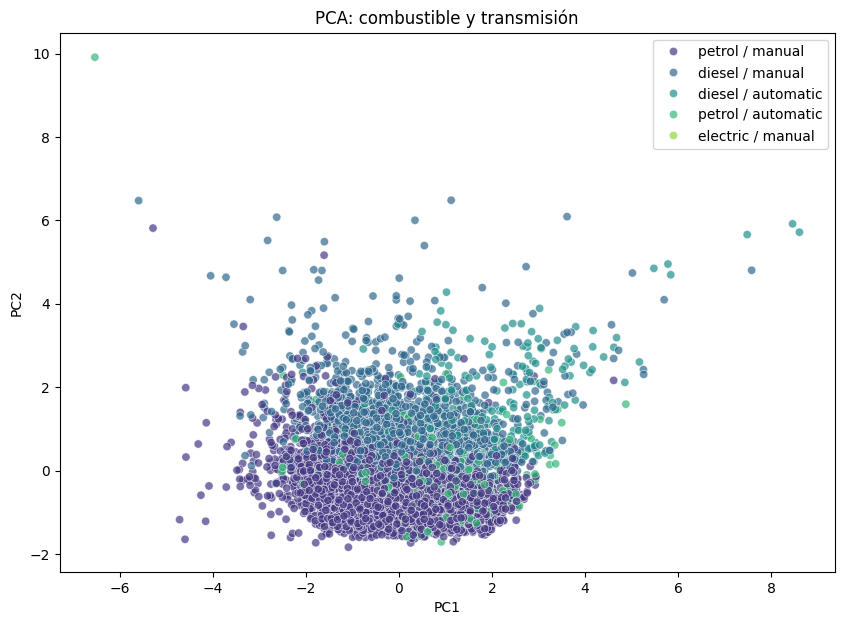

In [256]:
df_clean['fuel_type_new'] = df_clean['fuel_type'].replace({
    'petrol & cng': 'petrol',
    'petrol & lpg': 'petrol',
})
df_clean['fuel_trans'] = df_clean['fuel_type_new'] + " / " + df_clean['transmission']

plt.figure(figsize=(10,7))
sns.scatterplot(
    x=X_pca[:,0], y=X_pca[:,1],
    hue=df_clean['fuel_trans'],   # nueva variable combinada
    palette="viridis", alpha=0.7
)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA: combustible y transmisión")
plt.legend(loc='best')
plt.show()

#### Visualización 3D

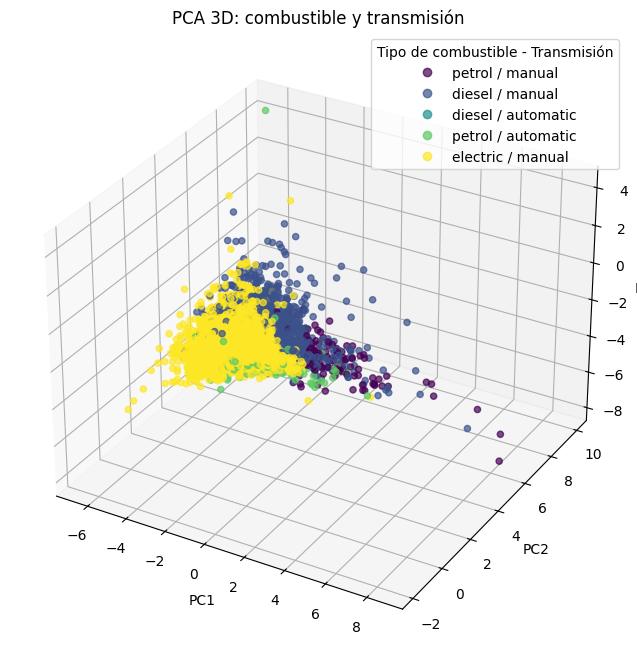

In [257]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Asegúrate de haber hecho PCA con al menos 3 componentes
X_pca_3d = pipeline.transform(X)[:, :3]  # tomar PC1, PC2, PC3

# Gráfico 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    X_pca_3d[:, 0],   # PC1
    X_pca_3d[:, 1],   # PC2
    X_pca_3d[:, 2],   # PC3
    c=pd.Categorical(df_clean['fuel_trans']).codes,  # colores por fuel_trans
    cmap='viridis',
    alpha=0.7
)

# Etiquetas
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("PCA 3D: combustible y transmisión")

# Leyenda
handles, labels = scatter.legend_elements(prop="colors", alpha=0.7)
ax.legend(handles, df_clean['fuel_trans'].unique(), title="Tipo de combustible - Transmisión")

plt.show()


#### Interpretación

In [258]:
# Obtener nombres de columnas después del preprocesamiento
num_features = ['sale_price', 'yr_mfr', 'kms_run']

# Sacar nombres creados por OneHotEncoder
cat_ohe = pipeline.named_steps['preprocessor'].named_transformers_['cat']
cat_feature_names = cat_ohe.get_feature_names_out()

# Juntar numéricas + categóricas transformadas
feature_names = num_features + list(cat_feature_names)

# Crear DataFrame con loadings
n_components = pipeline.named_steps['pca'].n_components_
loadings = pipeline.named_steps['pca'].components_.T

loadings_df = pd.DataFrame(loadings,columns=[f'PC{i+1}' for i in range(n_components)],index=feature_names)

print(loadings_df)


                             PC1       PC2       PC3
sale_price              0.585662  0.504341 -0.557975
yr_mfr                  0.683767 -0.010405  0.720144
kms_run                -0.423153  0.743606  0.360997
fuel_type_diesel        0.046568  0.304837  0.012483
fuel_type_electric      0.000096 -0.000327  0.000848
fuel_type_petrol       -0.024879 -0.311050 -0.080810
fuel_type_petrol & cng -0.016623  0.006492  0.071405
fuel_type_petrol & lpg -0.005163  0.000047 -0.003925
transmission_automatic  0.060472  0.037828 -0.118188
transmission_manual    -0.060472 -0.037828  0.118188


El **primer componente principal (PC1)** está fuertemente asociado con el precio de venta y el año de fabricación, ambos con cargas positivas altas, mientras que el kilometraje aparece con carga negativa. Esto significa que PC1 distingue entre autos más recientes y caros con poco uso (valores positivos) y autos antiguos, más baratos y con mayor desgaste (valores negativos). En otras palabras, este componente puede interpretarse como un eje de valor del vehículo, que combina modernidad, precio y kilometraje en una misma dimensión.

El **segundo componente principal (PC2)** está fuertemente determinado por el kilometraje, con un aporte positivo muy alto, acompañado del precio de venta y del combustible diésel, que también muestran cargas positivas importantes. En contraste, los autos a gasolina cargan de forma negativa en este componente. De este modo, PC2 diferencia a los vehículos diésel con mayor kilometraje y precio de aquellos de gasolina, que se proyectan en el lado opuesto.

El **tercer componente principal (PC3)** se relaciona principalmente con la antigüedad, pues el año de fabricación muestra la carga más alta y positiva, mientras que el precio de venta aparece en sentido contrario. Esto indica un contraste entre autos recientes y su relación con el costo. Además, el kilometraje contribuye en la misma dirección que el año, y las variables de transmisión también participan: los autos manuales tienden a ubicarse en un extremo y los automáticos en el opuesto. En menor medida, los combustibles alternativos como “petrol & cng” también suman a este eje.

## **6. Generación de la recomendación**

Para recomendar el “mejor carro a comprar” se propone construir un **score ponderado** que integre las variables seleccionadas.Se define el **score total** como:

$$\text{Score} = 0.30P + 0.25A + 0.20K + 0.125F + 0.125T$$

donde cada componente representa una variable normalizada en el rango $[0,1]$, y los coeficientes reflejan su importancia relativa en la decisión de compra.  Valores más altos indican una **mejor opción**

## Variables y su tratamiento

1. Precio de venta (`sale_price`)
* **Peso asignado:** 0.30 → Es el factor más decisivo para un comprador promedio.
* **Normalización:** valores más bajos son mejores, por lo tanto se invierte la escala.

$$P = 1 - \frac{\text{sale\_price} - \min(\text{sale\_price})}{\max(\text{sale\_price}) - \min(\text{sale\_price})}$$


2. Año de fabricación (`yr_mfr`)

* **Peso asignado:** 0.25 → Refleja la importancia de la antigüedad y la vida útil.
* **Normalización:** los vehículos más recientes reciben mayor puntaje.

$$A = \frac{\text{yr\_mfr} - \min(\text{yr\_mfr})}{\max(\text{yr\_mfr}) - \min(\text{yr\_mfr})}$$



3. Kilometraje (`kms_run`)

* **Peso asignado:** 0.20 → Buen predictor de desgaste y condición del vehículo.
* **Normalización:** menor kilometraje es preferible, por lo que se invierte la escala.

$$K = 1 - \frac{\text{kms\_run} - \min(\text{kms\_run})}{\max(\text{kms\_run}) - \min(\text{kms\_run})}$$


4. Tipo de combustible (`fuel_type`)

* **Peso asignado:** 0.125 → Impacta en costos de operación y sostenibilidad.
* **Asignación de puntajes:** según preferencia/perfil del potencial comprador.



5. Transmisión (`transmission`)

* **Peso asignado:** 0.125 → Relacionado con comodidad y valor de reventa.
* **Asignación de puntajes:** dsegún preferencia/perfil del potencial comprador.


**Estrategia de ranking**

1. Definir perfil del potencial cliente/comprador.
2. Calcular el score normalizado para cada carro.
3. Ordenar de mayor a menor score.
4. Seleccionar el Top-N carros recomendados (ej. los 5 mejores).



A continuación vamos a crear un perfil de usuario para realizar el ejercicio de recomendación.

**Perfil: Conductor urbano que prefiere la transmisión automática y busca una solución eléctrica. Como alternativas secundarias considera el diésel y, en última opción, la petroleo puro o sus combinaciones.**

In [259]:

# --- Normalización de variables numéricas ---
df_norm = df_clean.copy()

# Precio (invertido: más bajo es mejor)
df_norm['P'] = 1 - (df_norm['sale_price'] - df_norm['sale_price'].min()) / (df_norm['sale_price'].max() - df_norm['sale_price'].min())

# Año de fabricación (más nuevo es mejor)
df_norm['A'] = (df_norm['yr_mfr'] - df_norm['yr_mfr'].min()) / (df_norm['yr_mfr'].max() - df_norm['yr_mfr'].min())

# Kilometraje (invertido: menos kms es mejor)
df_norm['K'] = 1 - (df_norm['kms_run'] - df_norm['kms_run'].min()) / (df_norm['kms_run'].max() - df_norm['kms_run'].min())

# --- Mapear variables categóricas ---
fuel_scores = { 'electric': 1.0, 'diesel': 0.7, 'petrol': 0.2, 'petrol & cng': 0.2, 'petrol & lpg': 0.2 }


df_norm['F'] = df_norm['fuel_type'].map(fuel_scores)

transmission_scores = {'automatic': 1.0,'manual': 0.7}

df_norm['T'] = df_norm['transmission'].map(transmission_scores)

# --- Score ponderado ---
df_norm['Score'] = 0.30 * df_norm['P'] + 0.25 * df_norm['A'] + 0.20 * df_norm['K'] + 0.125 * df_norm['F'] + 0.125 * df_norm['T']

# --- Ranking ---
df_ranked = df_norm.sort_values('Score', ascending=False).reset_index(drop=True)

# Mostrar Top 5 recomendados
print("=== Top 5 carros recomendados ===")
print(df_ranked[[ 'yr_mfr', 'fuel_type', 'transmission', 'sale_price', 'kms_run', 'Score']].head(5))


=== Top 5 carros recomendados ===
   yr_mfr fuel_type transmission  sale_price  kms_run     Score
0    2016  electric       manual      366399     5000  0.882506
1    2019    diesel    automatic      818599    16641  0.873779
2    2019    diesel    automatic      907599     8091  0.869543
3    2018    diesel    automatic      715899    25839  0.868875
4    2016  electric       manual      350000    58133  0.867181


### 7. Transparencia en el uso de IA

- Se utilizó la IA para mejorar la redacción de los insights. Para ello se usó el prompt:

```python
"""Se está realizando un análisis sobre las siguientes cinco variables:
1. **Precio de venta (`sale_price`):** Es la variable más crítica porque los compradores suelen tener un presupuesto definido. Permite filtrar opciones viables bajo el presupuesto del comprador.
2. **Año de fabricación (`yr_mfr`)**
Influye en la depreciación del carro. A mayor antigüedad, menor valor de reventa y mayor probabilidad de costos de mantenimiento.
3. **Kilometraje (`kms_run`):** Es un indicador directo del desgaste del vehículo. Un carro con menor kilometraje suele tener mejor estado mecánico, aunque depende de uso y mantenimiento.
4. **Tipo de combustible (`fuel_type`):** Determina el costo operativo (ej. gasolina vs. diésel vs. eléctrico). Importante para compradores que priorizan ahorro en consumo o sostenibilidad.
5. **Transmisión (`transmission`):** Es clave para la experiencia de manejo y preferencias del usuario (manual vs. automática). También afecta el valor de reventa según el mercado.

Del análisis se obtuvo el siguiente insight: [texto insight]

Instrucción: mejora la redacción del insight, manten un lenguaje formal pero claro. No uses bulletpoints, solo parrafos. No agreges información diferente a la mencionada.
"""
```
